### Mount Drive and hold imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#imports
!pip install geocoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_letters


import geocoder
import seaborn as sns

### Load in initial housing data

In [7]:
#import data
# housing_df = pd.read_csv("housing.csv")
housing_df = pd.read_csv("/content/drive/MyDrive/housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
#clean data (dropping nulls, na)
# Drop duplicate rows
housing_df = housing_df.drop_duplicates()

In [11]:
# Drow rows that have any nulls (NaN) in them
housing_df = housing_df.dropna(axis = 0)

### One time run step to extract zip code, city and county from the housing data

In [9]:
# Take in a row from the data frame and extract the zip code (postal), city and county associated with the latitude and longitude
def extractGeoLocationData(row):
    try:
        g = geocoder.mapquest([row['latitude'], row['longitude']], method='reverse', key='p39RsNn4xWJHVlfQ5l0IDHw4pDCA8bPE').json
        # Store the variables in a python object.
        geoData = {}
        geoData['postal'] = g['postal']
        geoData['city'] = g['city']
        geoData['county'] = g['county']
        return geoData
    except:
        geoData = {}
        geoData['postal'] = None
        geoData['city'] = None
        geoData['county'] = None
        return geoData

In [1]:
# Due to the use of the mapquest API, a maximum of 15000 API calls can be made, all members had to create an account and extract the geolocation
# data for chunks of the data until all data points have been run.

# Slice the housing_df dataframe and run the geolocation extractor.
def geoLocationExtractor(start, end):
  sliced_df = housing_df.iloc[start:end]
  return sliced_df.apply(lambda row: extractGeoLocationData(row), axis=1)

slicedGeoLocationData = geoLocationExtractor(10000, 15000)
slicedGeoLocationData

NameError: ignored

In [2]:
# Reset the indices in order to iterate through the list.
slicedGeoLocationData = slicedGeoLocationData.reset_index(drop=True)
slicedGeoLocationData

NameError: ignored

In [ ]:
# Generate a pandas dataframe and run through the list to store the postal code, city and county.
sliced_geo_df = pd.DataFrame()
postalList = []
cityList = []
countyList = []
def getArray(val):
  postalList.append(val['postal'])
  cityList.append(val['city'])
  countyList.append(val['county'])

for i in range(len(slicedGeoLocationData)):
  try:
    getArray(slicedGeoLocationData[i])
  except Exception as err:
    print(err)
    postalList.append(None)
    cityList.append(None)
    countyList.append(None)

sliced_geo_df['postal'] = postalList
sliced_geo_df['city'] = cityList
sliced_geo_df['county'] = countyList

In [ ]:
sliced_geo_df

In [ ]:
# Store the partial data in a temporary csv
sliced_geo_df.to_csv('/content/drive/MyDrive/partialData3.csv', index=False)

In [ ]:
# Once all of the data has been run through, read all the csv files partially generated.
data1_df = pd.read_csv("/content/drive/MyDrive/partialData1.csv")
data2_df = pd.read_csv("/content/drive/MyDrive/partialData2.csv")
data3_df = pd.read_csv("/content/drive/MyDrive/partialData3.csv")

In [ ]:
# Build out a dataframe of the partial data and append in the order they were read.
data_df = data1_df.append(data2_df, ignore_index=True)
data_df = data_df.append(data3_df, ignore_index=True)
data_df = data_df.append(data4_df, ignore_index=True)

In [ ]:
# Take in the housing dataframe and update all rows with the postal, city and county data.
housing_zip_df = housing_df.reset_index(drop=True)
housing_zip_df[['postal', 'city', 'county']] = data_df[['postal', 'city', 'county']]

# Take in the postal code and only hold the first 5 digits (zip-code).
housing_zip_df['postal'] = housing_zip_df['postal'].apply(lambda x: int(x[0:5]) if type(x) == str else x)

In [ ]:
# Write the updated data with zip information into another csv in order to not need to run the above procedure again.
housing_zip_df.to_csv('/content/drive/MyDrive/housing_with_zip.csv', index=False)

### Load in the updated Zip Code CSV

In [12]:
housing_with_zip_df = pd.read_csv("/content/drive/MyDrive/housing_with_zip.csv")

In [13]:
# Since some rows were unable to find appropriate zip codes from the data, drop any nulls found in the data.
housing_with_zip_df = housing_df.dropna(axis = 0)
housing_with_zip_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
housing_df = housing_with_zip_df

### EDA Visuals (e.g. lat/long plots, correlation plots, any other interesting plots)

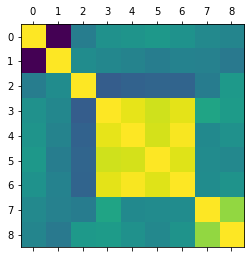

In [15]:
plt.matshow(housing_df.corr())
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d51deae10>,
      dtype=object)

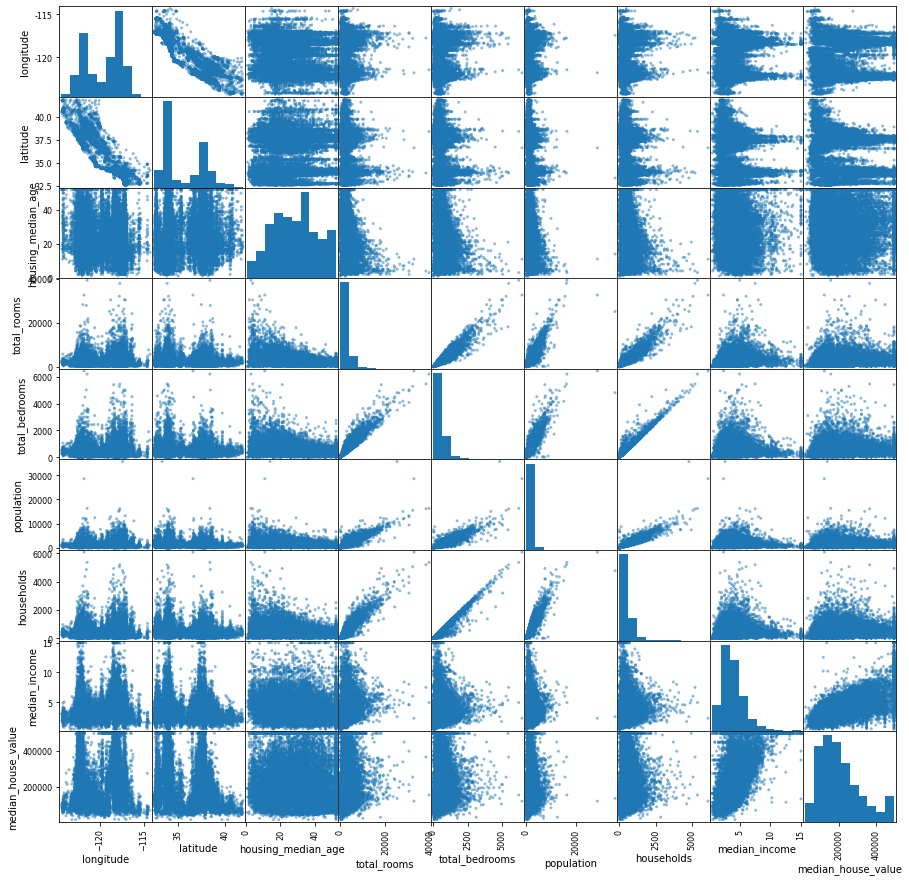

In [16]:
pd.plotting.scatter_matrix(housing_df,figsize=(15,15))

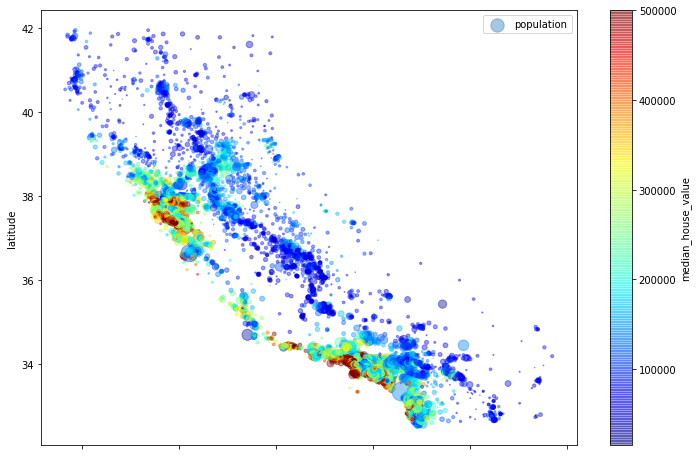

In [17]:
#plot median house price vs. location
#TO-DO: make our own

housing_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing_df['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [18]:
# Correlation Matrix
correlation_matrix = housing_df.corr()
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,0.688355
median_house_value,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,1.000000


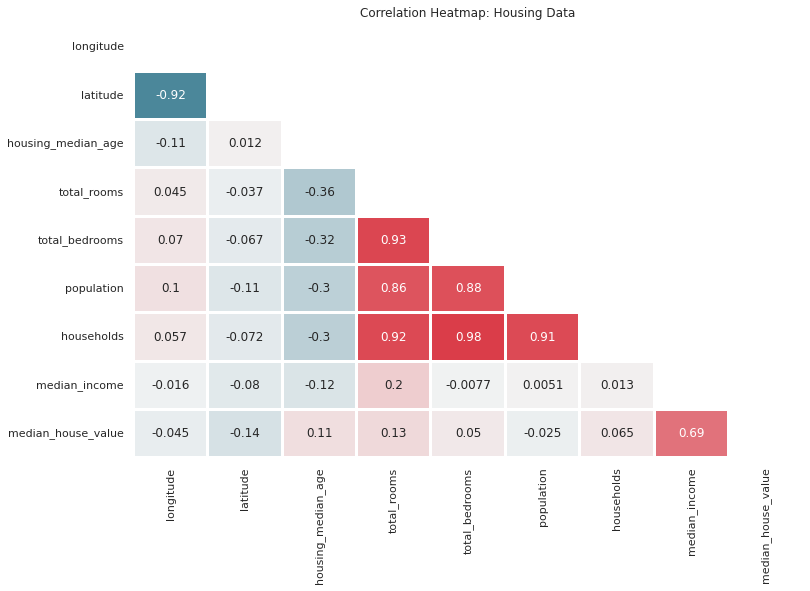

In [19]:
sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, center='light')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap, mask=mask, lw=2, cbar=False)

plt.title("Correlation Heatmap: Housing Data")
plt.show()